Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
weather = pd.read_csv("../data/weather.csv")

In [3]:
weather.head()

,city_latitude,city_longitude,city_resolvedAddress,city_address,city_timezone,city_tzoffset,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,hour_icon,hour_source,hour_stations
0,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,...,1020.0,0.0,91.5,0.0,NaN,0.0,Overcast,snow,obs,remote
1,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,...,1021.0,0.2,88.2,0.0,NaN,0.0,Partially cloudy,fog,obs,remote
2,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,...,1022.0,10.0,100.0,NaN,NaN,NaN,Overcast,cloudy,obs,33177099999
3,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,...,1021.0,0.1,92.0,0.0,NaN,0.0,Overcast,fog,obs,remote
4,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,...,1021.0,0.0,93.8,0.0,NaN,0.0,Overcast,cloudy,obs,remote


# Analyze Data

## Weather Dataset

### Weather Dataset Overview


In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608304 entries, 0 to 608303
Data columns (total 65 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   city_latitude         608304 non-null  float64
 1   city_longitude        608304 non-null  float64
 2   city_resolvedAddress  608304 non-null  object 
 3   city_address          608304 non-null  object 
 4   city_timezone         608304 non-null  object 
 5   city_tzoffset         608304 non-null  float64
 6   day_datetime          608304 non-null  object 
 7   day_datetimeEpoch     608304 non-null  int64  
 8   day_tempmax           608304 non-null  float64
 9   day_tempmin           608304 non-null  float64
 10  day_temp              608304 non-null  float64
 11  day_feelslikemax      608304 non-null  float64
 12  day_feelslikemin      608304 non-null  float64
 13  day_feelslike         608304 non-null  float64
 14  day_dew               608304 non-null  float64
 15  


The output of `weather.info()` reveals that this dataset contains a **significant number of missing values** across multiple columns.

Because of this, each column should be **individually evaluated** to determine the appropriate handling strategy:
- **Impute missing values**
- **Keep as-is**
- Or **drop the column entirely**

In addition, both the `day_datetime` and `hour_datetime` columns are currently stored as `object` types.
For proper time-based analysis, we will:
- Convert them to `datetime` format,
- And combine them into a single unified `datetime` column to simplify processing and ensure consistency.

There are also time-related columns such as `day_sunrise` and `day_sunset`, which will also be converted to proper `datetime` format.

In [5]:
weather["datetime"] = pd.to_datetime(
    weather["day_datetime"].astype(str) + " " + weather["hour_datetime"].astype(str),
    format="%Y-%m-%d %H:%M:%S"
)

weather["sunrise_datetime"] = pd.to_datetime(
    weather["day_datetime"].astype(str) + " " + weather["day_sunrise"].astype(str),
    format="%Y-%m-%d %H:%M:%S"
)

weather["sunset_datetime"] = pd.to_datetime(
    weather["day_datetime"].astype(str) + " " + weather["day_sunset"].astype(str),
    format="%Y-%m-%d %H:%M:%S"
)
weather.drop(["day_datetime", "hour_datetime", "day_sunset", "day_sunrise"], axis=1, inplace=True)

### Understanding the Method for Handling Missing Values

Before applying any filling or deletion strategy, it's important to **fully understand the context and structure** of missing data in the dataset.

Our approach consists of the following steps:

1. **Explore each feature**:
   Determine the percentage and pattern of missing values in each column.
   Some columns may have isolated gaps (suitable for filling), while others may be mostly empty (better to drop).

2. **Evaluate relevance**:
   Assess whether the column is important for further analysis or modeling.
   Columns with low importance or no correlation may be dropped regardless of missingness.

3. **Check the duration and nature of gaps**:
   For time-series data, long gaps might require different handling than short, isolated ones.
   Short gaps are safely fillable with **`ffill`/`bfill`**.

4. **Apply missing value treatment after reviewing all features**:
   This ensures that the method is applied **consistently across the dataset**, avoiding unnecessary fragmentation or bias.

Only after this full review, we will proceed with filling or removing missing values based on the nature of each column.


In [6]:
def find_longest_missing_gap(df, target_column: str):
    """
    Finds and prints the longest continuous time gap where the values are missing (NaN)
    in a specified column of a DataFrame.

    Parameters:
    - df (pd.DataFrame): The dataset containing the time and target columns.
    - target_column (str): The name of the column to check for missing values.

    Returns:
    - None. Prints the start, end, and duration of the longest missing interval.
    """

    df = df.copy()
    df = df.sort_values("datetime")
    missing = df[target_column].isna()
    group_id = missing.ne(missing.shift()).cumsum()

    missing_groups = df[missing].groupby(group_id)

    gap_info = missing_groups["datetime"].agg(["first", "last"])
    gap_info["duration"] = gap_info["last"] - gap_info["first"]

    if not gap_info.empty:
        longest = gap_info.loc[gap_info["duration"].idxmax()]
        print("Longest period with missing values in column:", target_column)
        print(f"– From: {longest["first"]}")
        print(f"– To  : {longest["last"]}")
    else:
        print(f"No missing values found in column {target_column}.")

#### Checking for Missing Values

1) **Visibility**


In [7]:
find_longest_missing_gap(weather, "day_visibility")

Longest period with missing values in column: day_visibility
– From: 2024-03-31 02:00:00
– To  : 2024-03-31 04:00:00


We can see that the longest gap in this column is just **2 hours**,
which makes it reasonable to apply either **forward fill (`ffill`)** or **backward fill (`bfill`)** as an effective way to handle the missing values without introducing significant distortion.

Additionally, we have a corresponding feature, `hour_visibility`, so let's examine that as well.

In [8]:
find_longest_missing_gap(weather, "hour_visibility")

Longest period with missing values in column: hour_visibility
– From: 2023-03-26 02:00:00
– To  : 2023-03-26 04:00:00


We can see that the longest gap in both columns is just **2 hours**. Let’s now check how they interact with each other.

In [9]:
weather[["datetime", "day_visibility", "hour_visibility"]]

,datetime,day_visibility,hour_visibility
0,2022-02-24 00:00:00,12.2,0.0
1,2022-02-24 01:00:00,12.2,0.2
2,2022-02-24 02:00:00,12.2,10.0
3,2022-02-24 03:00:00,12.2,0.1
4,2022-02-24 04:00:00,12.2,0.0
...,...,...,...
608299,2025-03-01 19:00:00,7.0,NaN
608300,2025-03-01 20:00:00,7.0,10.0
608301,2025-03-01 21:00:00,7.0,NaN
608302,2025-03-01 22:00:00,7.0,NaN


We can notice that `day_visibility` has the same value throughout the entire day. This might suggest that it represents a fixed value, possibly the mean of `hour_visibility`. Let’s check it now.

In [10]:
weather["hour_visibility"].iloc[:24].mean()

np.float64(12.154166666666667)

So, we were correct in assuming that `day_visibility` represents the mean of `hour_visibility`. Since we will be storing the data on an hourly basis, the `day_visibility` column is unnecessary for our model. Therefore, we will drop this column.

Additionally, we noticed that the `hour_visibility` column has missing values, which we will address by applying the **forward fill (`ffill`)** method.

2) **Solarradiation, Solarenergy, UVindex**


In [11]:
find_longest_missing_gap(weather, "day_solarradiation")

Longest period with missing values in column: day_solarradiation
– From: 2024-10-28 00:00:00
– To  : 2024-10-28 23:00:00


In [12]:
find_longest_missing_gap(weather, "day_solarenergy")

Longest period with missing values in column: day_solarenergy
– From: 2024-10-28 00:00:00
– To  : 2024-10-28 23:00:00


In [13]:
find_longest_missing_gap(weather, "day_uvindex")

Longest period with missing values in column: day_uvindex
– From: 2024-10-28 00:00:00
– To  : 2024-10-28 23:00:00


These three columns share the same missing value pattern, including identical gap locations and durations.
The longest missing stretch is around **1 day**, which is not a small gap — but also not too long to make reconstruction unreliable.

Simple methods like `ffill` or `bfill` could work.

Let's now examine corresponding features: `hour_solarradiation`,`hour_solarenergy` and `hour_uvindex`.

In [14]:
find_longest_missing_gap(weather, "hour_solarradiation")

Longest period with missing values in column: hour_solarradiation
– From: 2024-10-28 00:00:00
– To  : 2024-10-28 23:00:00


In [15]:
find_longest_missing_gap(weather, "hour_solarenergy")

Longest period with missing values in column: hour_solarenergy
– From: 2024-10-28 00:00:00
– To  : 2024-10-28 23:00:00


In [16]:
find_longest_missing_gap(weather, "hour_uvindex")

Longest period with missing values in column: hour_uvindex
– From: 2024-10-28 00:00:00
– To  : 2024-10-28 23:00:00


We can see that these features have the same largest gap. Let's check how they interact with each other.


In [17]:
weather[["datetime", "day_solarradiation", "hour_solarradiation", "day_solarenergy", "hour_solarenergy", "day_uvindex",
         "hour_uvindex"]]

,datetime,day_solarradiation,hour_solarradiation,day_solarenergy,hour_solarenergy,day_uvindex,hour_uvindex
0,2022-02-24 00:00:00,36.9,0.0,2.8,NaN,1.0,0.0
1,2022-02-24 01:00:00,36.9,0.0,2.8,NaN,1.0,0.0
2,2022-02-24 02:00:00,36.9,NaN,2.8,NaN,1.0,NaN
3,2022-02-24 03:00:00,36.9,0.0,2.8,NaN,1.0,0.0
4,2022-02-24 04:00:00,36.9,0.0,2.8,NaN,1.0,0.0
...,...,...,...,...,...,...,...
608299,2025-03-01 19:00:00,106.1,0.0,9.2,0.0,4.0,0.0
608300,2025-03-01 20:00:00,106.1,0.0,9.2,0.0,4.0,0.0
608301,2025-03-01 21:00:00,106.1,0.0,9.2,0.0,4.0,0.0
608302,2025-03-01 22:00:00,106.1,0.0,9.2,0.0,4.0,0.0


In [18]:
weather["hour_solarradiation"].iloc[:24].mean()

np.float64(36.9)

In [19]:
weather["hour_solarenergy"].iloc[:24].sum()

np.float64(2.8)

In [20]:
weather["hour_uvindex"].iloc[:24].max()

np.float64(1.0)

From the basic analysis, we can see that `day_solarradiation` is the mean of `hour_solarradiation` for the given day, `day_solarenergy` is the sum of `hour_solarenergy`, and `day_uvindex` is the maximum of `hour_uvindex`. Following the same logic as with the previous features, the `day_` attributes are redundant and unnecessary for our model.

3) **Preciptype**

In [21]:
find_longest_missing_gap(weather, "day_preciptype")

Longest period with missing values in column: day_preciptype
– From: 2024-04-29 23:00:00
– To  : 2024-05-05 00:00:00


In [22]:
weather["day_preciptype"].value_counts()

day_preciptype
rain                      244492
rain;snow                  77389
snow                       18790
rain;freezingrain;snow      1104
freezingrain;snow            168
rain;freezingrain             72
ice                           24
freezingrain;snow;ice         24
rain;snow;ice                 24
Name: count, dtype: int64

The `day_preciptype` column contains meaningful categorical information about types of precipitation, including multiple combined values (e.g., "rain;snow").

Although ~44% of the values are missing, it's reasonable to assume they indicate **no precipitation**.

Therefore, instead of dropping or ignoring the column, we will keep it and **fill missing values with `"none"`** to preserve clarity and make the data ready for modeling or analysis.


In [23]:
weather["hour_preciptype"].value_counts()

hour_preciptype
['rain']            43309
['rain', 'snow']    12162
['snow']             9268
['freezingrain']      122
['ice']                 4
Name: count, dtype: int64

In [24]:
weather[["datetime", "day_preciptype", "hour_preciptype"]]

,datetime,day_preciptype,hour_preciptype
0,2022-02-24 00:00:00,snow,['snow']
1,2022-02-24 01:00:00,snow,['snow']
2,2022-02-24 02:00:00,snow,['snow']
3,2022-02-24 03:00:00,snow,['snow']
4,2022-02-24 04:00:00,snow,['snow']
...,...,...,...
608299,2025-03-01 19:00:00,NaN,NaN
608300,2025-03-01 20:00:00,NaN,NaN
608301,2025-03-01 21:00:00,NaN,NaN
608302,2025-03-01 22:00:00,NaN,NaN


As with the previous features, the `day_` attributes are linked to their corresponding hourly values, so we will drop the `day_preciptype` column. Additionally, we observe that `hour_preciptype` stores data in a list format, so it’s better to convert it to a string and process it later.

In [25]:
find_longest_missing_gap(weather, "hour_precip")

Longest period with missing values in column: hour_precip
– From: 2022-03-01 02:00:00
– To  : 2022-03-01 02:00:00


In [26]:
weather[weather["hour_precip"] == 0].head()

,city_latitude,city_longitude,city_resolvedAddress,city_address,city_timezone,city_tzoffset,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,...,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,hour_icon,hour_source,hour_stations,datetime,sunrise_datetime,sunset_datetime
0,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,1645653600,4.9,0.7,2.6,...,0.0,NaN,0.0,Overcast,snow,obs,remote,2022-02-24 00:00:00,2022-02-24 07:13:36,2022-02-24 17:51:06
1,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,1645653600,4.9,0.7,2.6,...,0.0,NaN,0.0,Partially cloudy,fog,obs,remote,2022-02-24 01:00:00,2022-02-24 07:13:36,2022-02-24 17:51:06
2,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,1645653600,4.9,0.7,2.6,...,NaN,NaN,NaN,Overcast,cloudy,obs,33177099999,2022-02-24 02:00:00,2022-02-24 07:13:36,2022-02-24 17:51:06
3,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,1645653600,4.9,0.7,2.6,...,0.0,NaN,0.0,Overcast,fog,obs,remote,2022-02-24 03:00:00,2022-02-24 07:13:36,2022-02-24 17:51:06
4,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,1645653600,4.9,0.7,2.6,...,0.0,NaN,0.0,Overcast,cloudy,obs,remote,2022-02-24 04:00:00,2022-02-24 07:13:36,2022-02-24 17:51:06


Since some values in this column are already equal to `0`, and the total amount of missing data is small,
with the longest missing gap being just **1 hour**, we will use **forward fill (`ffill`)** as a suitable method to handle the missing values.

Let's also compare it with `day_precip`.

In [27]:
weather[["datetime", "hour_precip", "day_precip"]]

,datetime,hour_precip,day_precip
0,2022-02-24 00:00:00,0.0,0.118
1,2022-02-24 01:00:00,0.0,0.118
2,2022-02-24 02:00:00,0.0,0.118
3,2022-02-24 03:00:00,0.0,0.118
4,2022-02-24 04:00:00,0.0,0.118
...,...,...,...
608299,2025-03-01 19:00:00,0.0,0.000
608300,2025-03-01 20:00:00,0.0,0.000
608301,2025-03-01 21:00:00,0.0,0.000
608302,2025-03-01 22:00:00,0.0,0.000


We can see that `day_precip` is simply the sum of `hour_precip`. Following the same logic as with the previous features, we will drop the `day_precip` column.

### Filling Missing Data

In [28]:
# 1. Categorical columns: fill with 'none'
weather["hour_preciptype"] = weather["hour_preciptype"].fillna("none")

# 2. Columns to forward fill
ffill_columns = ["hour_precip", "hour_visibility",
                 "hour_solarradiation", "hour_solarenergy", "hour_uvindex"
                 ]
weather[ffill_columns] = weather.groupby("city_address")[ffill_columns].ffill()

In [29]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608304 entries, 0 to 608303
Data columns (total 64 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   city_latitude         608304 non-null  float64       
 1   city_longitude        608304 non-null  float64       
 2   city_resolvedAddress  608304 non-null  object        
 3   city_address          608304 non-null  object        
 4   city_timezone         608304 non-null  object        
 5   city_tzoffset         608304 non-null  float64       
 6   day_datetimeEpoch     608304 non-null  int64         
 7   day_tempmax           608304 non-null  float64       
 8   day_tempmin           608304 non-null  float64       
 9   day_temp              608304 non-null  float64       
 10  day_feelslikemax      608304 non-null  float64       
 11  day_feelslikemin      608304 non-null  float64       
 12  day_feelslike         608304 non-null  float64       
 13 

Currently, only one column still contains missing values and won't be dropped,
so we will apply the **backfill (`bfill`)** method specifically to that column to handle the remaining gaps.

In [30]:
weather["hour_solarenergy"] = weather.groupby("city_address")["hour_solarenergy"].bfill()

In [31]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608304 entries, 0 to 608303
Data columns (total 64 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   city_latitude         608304 non-null  float64       
 1   city_longitude        608304 non-null  float64       
 2   city_resolvedAddress  608304 non-null  object        
 3   city_address          608304 non-null  object        
 4   city_timezone         608304 non-null  object        
 5   city_tzoffset         608304 non-null  float64       
 6   day_datetimeEpoch     608304 non-null  int64         
 7   day_tempmax           608304 non-null  float64       
 8   day_tempmin           608304 non-null  float64       
 9   day_temp              608304 non-null  float64       
 10  day_feelslikemax      608304 non-null  float64       
 11  day_feelslikemin      608304 non-null  float64       
 12  day_feelslike         608304 non-null  float64       
 13 

With this, our missing value handling is complete.
While it's possible that some information was lost during the process, this is often an acceptable trade-off for achieving a clean and consistent dataset suitable for further analysis and modeling.

## Feature Analysis

### Analysis of Day_ Features

As we observed earlier, the `day_` features are closely related to the `hour_` features. Since we store data on an hourly basis, these `day_` features are not necessary for our analysis. Let's now examine the other `day_` features to determine if they are required for our future analysis.


1) **Temperature** (`tempmax`, `tempmin`, `temp`, `feelslike`, `feelslikemax`, `feelslikemin`)


These features are self-explanatory based on their names. Temperature-related attributes, such as `tempmax`, `tempmin`, `temp`, are valuable for our analysis. However, the `feelslike` attributes (including `hour_feelslike`) are less relevant, as they represent subjective perceptions of temperature, whereas we are interested in objective data (factual values).

2) **Dew, Humidity**

In [32]:
weather[["datetime", "day_dew", "hour_dew", "day_humidity", "hour_humidity"]]

,datetime,day_dew,hour_dew,day_humidity,hour_humidity
0,2022-02-24 00:00:00,0.0,0.8,83.7,89.18
1,2022-02-24 01:00:00,0.0,0.6,83.7,87.90
2,2022-02-24 02:00:00,0.0,1.2,83.7,88.58
3,2022-02-24 03:00:00,0.0,0.3,83.7,86.63
4,2022-02-24 04:00:00,0.0,0.1,83.7,87.85
...,...,...,...,...,...
608299,2025-03-01 19:00:00,-5.9,-5.5,81.2,73.09
608300,2025-03-01 20:00:00,-5.9,-4.6,81.2,81.17
608301,2025-03-01 21:00:00,-5.9,-6.1,81.2,68.31
608302,2025-03-01 22:00:00,-5.9,-6.2,81.2,71.36


In [33]:
weather["hour_dew"].iloc[:24].mean()

np.float64(0.04583333333333339)

In [34]:
weather["hour_humidity"].iloc[:24].mean()

np.float64(83.66458333333333)

Since `day_dew` and `day_humidity` simply represent the mean of the corresponding hourly values, they can be easily dropped.

3) **Precip**

In [35]:
weather[["datetime", "day_precipprob", "hour_precipprob", "day_precipcover"]]

,datetime,day_precipprob,hour_precipprob,day_precipcover
0,2022-02-24 00:00:00,100.0,0.0,4.17
1,2022-02-24 01:00:00,100.0,0.0,4.17
2,2022-02-24 02:00:00,100.0,0.0,4.17
3,2022-02-24 03:00:00,100.0,0.0,4.17
4,2022-02-24 04:00:00,100.0,0.0,4.17
...,...,...,...,...
608299,2025-03-01 19:00:00,0.0,0.0,0.00
608300,2025-03-01 20:00:00,0.0,0.0,0.00
608301,2025-03-01 21:00:00,0.0,0.0,0.00
608302,2025-03-01 22:00:00,0.0,0.0,0.00


`day_precipprob` follows the same pattern as the other `day_` features. Therefore, it can also be safely dropped.


4) **Snow**

In [36]:
weather[["datetime", "day_snow", "hour_snow", "day_snowdepth", "hour_snowdepth"]]

,datetime,day_snow,hour_snow,day_snowdepth,hour_snowdepth
0,2022-02-24 00:00:00,0.1,0.1,0.1,0.2
1,2022-02-24 01:00:00,0.1,0.0,0.1,0.2
2,2022-02-24 02:00:00,0.1,0.0,0.1,0.1
3,2022-02-24 03:00:00,0.1,0.0,0.1,0.1
4,2022-02-24 04:00:00,0.1,0.0,0.1,0.1
...,...,...,...,...,...
608299,2025-03-01 19:00:00,0.0,0.0,2.0,2.0
608300,2025-03-01 20:00:00,0.0,0.0,2.0,2.0
608301,2025-03-01 21:00:00,0.0,0.0,2.0,2.0
608302,2025-03-01 22:00:00,0.0,0.0,2.0,2.0


Same.

5) **Wind**

In [37]:
weather[["datetime", "day_windgust", "hour_windgust", "day_windspeed", "hour_windspeed", "day_winddir", "hour_winddir"]]

,datetime,day_windgust,hour_windgust,day_windspeed,hour_windspeed,day_winddir,hour_winddir
0,2022-02-24 00:00:00,32.4,31.3,15.5,15.5,252.7,275.6
1,2022-02-24 01:00:00,32.4,27.7,15.5,14.8,252.7,280.3
2,2022-02-24 02:00:00,32.4,29.2,15.5,14.4,252.7,310.0
3,2022-02-24 03:00:00,32.4,23.8,15.5,13.3,252.7,295.1
4,2022-02-24 04:00:00,32.4,24.5,15.5,13.3,252.7,305.8
...,...,...,...,...,...,...,...
608299,2025-03-01 19:00:00,26.6,11.5,12.2,5.8,164.8,174.9
608300,2025-03-01 20:00:00,26.6,13.0,12.2,0.0,164.8,170.5
608301,2025-03-01 21:00:00,26.6,11.9,12.2,6.8,164.8,168.7
608302,2025-03-01 22:00:00,26.6,12.6,12.2,7.2,164.8,173.4


In [38]:
weather["hour_windgust"].iloc[:24].max()

np.float64(32.4)

In [39]:
weather["hour_windspeed"].iloc[:24].max()

np.float64(15.5)

Again, the same.

6) Other

In [40]:
weather[["datetime", "day_pressure", "hour_pressure", "day_cloudcover", "hour_cloudcover"]]

,datetime,day_pressure,hour_pressure,day_cloudcover,hour_cloudcover
0,2022-02-24 00:00:00,1022.3,1020.0,72.3,91.5
1,2022-02-24 01:00:00,1022.3,1021.0,72.3,88.2
2,2022-02-24 02:00:00,1022.3,1022.0,72.3,100.0
3,2022-02-24 03:00:00,1022.3,1021.0,72.3,92.0
4,2022-02-24 04:00:00,1022.3,1021.0,72.3,93.8
...,...,...,...,...,...
608299,2025-03-01 19:00:00,1030.4,1030.0,91.1,100.0
608300,2025-03-01 20:00:00,1030.4,1029.6,91.1,100.0
608301,2025-03-01 21:00:00,1030.4,1029.0,91.1,99.6
608302,2025-03-01 22:00:00,1030.4,1029.0,91.1,98.2


In [41]:
weather["hour_pressure"].iloc[:24].mean()

np.float64(1022.2624999999999)

In [42]:
weather["hour_cloudcover"].iloc[:24].mean()

np.float64(72.325)

Also, the same.

In [43]:
weather[["day_datetimeEpoch", "hour_datetimeEpoch"]]

,day_datetimeEpoch,hour_datetimeEpoch
0,1645653600,1645653600
1,1645653600,1645657200
2,1645653600,1645660800
3,1645653600,1645664400
4,1645653600,1645668000
...,...,...
608299,1740780000,1740848400
608300,1740780000,1740852000
608301,1740780000,1740855600
608302,1740780000,1740859200


We observe the same pattern here, and since we will store `datetime` with hours, the `day_datetimeEpoch` feature becomes redundant.

Additionally, features like `conditions`, `description`, and `icon` are similar to the `hour_conditions` and `hour_preciptype` columns. Since they provide redundant information, they will be dropped. Furthermore, features like `stations` and `source` do not offer any meaningful insights for our project, so they will also be removed.


### Drop mentioned features

In [44]:
weather.drop(["day_visibility", "day_solarenergy", "day_solarradiation", "day_uvindex", "day_preciptype", "day_precip",
              "hour_feelslike", "day_feelslikemax", "day_feelslikemin", "day_feelslike", "day_dew", "day_humidity",
              "day_precipprob", "day_snow", "day_snowdepth", "day_windgust",
              "day_winddir", "day_windspeed",
              "day_pressure", "day_cloudcover", "day_conditions", "day_description", "day_icon", "day_source",
              "day_stations", "hour_icon", "hour_source", "hour_stations", "day_datetimeEpoch"],
             axis=1,
             inplace=True)

### Analysis of Categorical Features

In [45]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608304 entries, 0 to 608303
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   city_latitude         608304 non-null  float64       
 1   city_longitude        608304 non-null  float64       
 2   city_resolvedAddress  608304 non-null  object        
 3   city_address          608304 non-null  object        
 4   city_timezone         608304 non-null  object        
 5   city_tzoffset         608304 non-null  float64       
 6   day_tempmax           608304 non-null  float64       
 7   day_tempmin           608304 non-null  float64       
 8   day_temp              608304 non-null  float64       
 9   day_precipcover       608304 non-null  float64       
 10  day_sunriseEpoch      608304 non-null  int64         
 11  day_sunsetEpoch       608304 non-null  int64         
 12  day_moonphase         608304 non-null  float64       
 13 

In [46]:
weather["city_resolvedAddress"].value_counts()

city_resolvedAddress
Луцьк, Луцький район, Україна           26448
Кропивницький, Україна                  26448
Дніпро, Україна                         26448
Київ, Україна                           26448
Херсон, Україна                         26448
Чернівці, Україна                       26448
Чернігів, Україна                       26448
Одеса, Україна                          26448
Миколаїв, Україна                       26448
Харків, Україна                         26448
Хмельницька область, Україна            26448
Донецьк, Україна                        26448
Ужгород, Ужгородський район, Україна    26448
Запоріжжя, Україна                      26448
Рівне, Україна                          26448
Житомир, Україна                        26448
Тернопіль, Україна                      26448
Полтава, Україна                        26448
Львів, Україна                          26448
Івано-Франківськ, Україна               26448
Черкаси, Україна                        26448
Суми, Україна

In [47]:
weather["city_address"].value_counts()

city_address
Lutsk,Ukraine              26448
Kropyvnytskyi,Ukraine      26448
Dnipro,Ukraine             26448
Kyiv,Ukraine               26448
Kherson,Ukraine            26448
Chernivtsi,Ukraine         26448
Chernihiv,Ukraine          26448
Odesa,Ukraine              26448
Mykolaiv,Ukraine           26448
Kharkiv,Ukraine            26448
Khmelnytskyi,Ukraine       26448
Donetsk,Ukraine            26448
Uzhgorod,Ukraine           26448
Zaporozhye,Ukraine         26448
Rivne,Ukraine              26448
Zhytomyr,Ukraine           26448
Ternopil,Ukraine           26448
Poltava,Ukraine            26448
Lviv,Ukraine               26448
Ivano-Frankivsk,Ukraine    26448
Cherkasy,Ukraine           26448
Sumy,Ukraine               26448
Vinnytsia,Ukraine          26448
Name: count, dtype: int64

As we can see, these features are quite similar, so there's no need to retain both. We will keep one and drop the other. Additionally, since we plan to merge on Ukrainian city names, we will drop the `city_address` column.


In [48]:
weather["city_timezone"].value_counts()

city_timezone
Europe/Kiev          555408
Europe/Uzhgorod       26448
Europe/Zaporozhye     26448
Name: count, dtype: int64

Even though they are different, actual time is the same, so it is also useless column

In [49]:
weather["hour_conditions"].value_counts()

hour_conditions
Partially cloudy                            230974
Overcast                                    217750
Clear                                       119719
Rain, Overcast                               19365
Rain, Partially cloudy                        9720
Snow, Rain, Overcast                          5666
Snow, Overcast                                2950
Snow, Rain, Partially cloudy                  1057
Snow, Partially cloudy                         566
Rain                                           395
Freezing Drizzle/Freezing Rain, Overcast        61
Snow                                            43
Snow, Rain                                      35
Ice, Overcast                                    1
Rain, Fog                                        1
Snow, Rain, Fog                                  1
Name: count, dtype: int64

### Analysis of Numerical Features

In [50]:
weather.describe()

,city_latitude,city_longitude,city_tzoffset,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,datetime,sunrise_datetime,sunset_datetime
count,608304.000000,608304.000000,608304.0,608304.000000,608304.000000,608304.000000,608304.000000,6.083040e+05,6.083040e+05,608304.000000,...,608304.000000,608304.00000,608304.00000,608304.000000,608304.000000,608304.000000,608304.000000,608304,608304,608304
mean,49.143238,30.142514,2.0,15.203232,6.253993,10.721077,6.553061,1.693240e+09,1.693284e+09,0.489195,...,189.830264,1016.91840,15.19198,64.811065,141.840411,0.520499,1.404909,2023-08-29 00:05:03.811251456,2023-08-28 19:02:18.310255872,2023-08-29 07:17:01.435697152
min,46.472500,22.285100,2.0,-14.300000,-50.300000,-17.500000,0.000000,1.645676e+09,1.645715e+09,0.000000,...,0.000000,973.00000,0.00000,0.000000,0.000000,0.000000,0.000000,2022-02-24 00:00:00,2022-02-24 06:19:37,2022-02-24 17:05:06
25%,48.292400,25.935500,2.0,5.900000,-0.200000,2.800000,0.000000,1.669441e+09,1.669472e+09,0.250000,...,98.000000,1011.20000,10.00000,30.000000,0.000000,0.000000,0.000000,2022-11-26 11:45:00,2022-11-26 07:29:18,2022-11-26 16:07:54
50%,49.416800,30.737100,2.0,15.100000,6.100000,10.600000,4.170000,1.693277e+09,1.693326e+09,0.500000,...,191.900000,1016.60000,10.00000,80.000000,5.000000,0.100000,0.000000,2023-08-29 00:30:00,2023-08-29 05:41:56,2023-08-29 19:16:49
75%,50.253600,34.551700,2.0,24.600000,13.200000,18.800000,8.330000,1.717035e+09,1.717092e+09,0.750000,...,287.200000,1022.00000,24.10000,99.900000,216.200000,0.800000,2.000000,2024-05-30 12:15:00,2024-05-30 05:02:15,2024-05-30 21:00:47
max,51.493700,37.814500,2.0,60.400000,27.200000,33.200000,100.000000,1.740806e+09,1.740846e+09,1.000000,...,360.000000,1050.00000,75.00000,100.000000,952.000000,3.400000,10.000000,2025-03-01 23:00:00,2025-03-01 07:12:24,2025-03-01 18:14:48
std,1.337209,4.303973,0.0,10.592473,8.162055,9.207622,12.103297,2.748640e+07,2.748407e+07,0.289963,...,106.383976,8.68127,9.62958,37.318628,220.458051,0.789653,2.221883,NaN,NaN,NaN


### Feature Review: Potential Issues & Considerations

1. **`city_tzoffset`**
   This feature has only **one unique value**, making it redundant for modeling.
   Can be safely removed.

2. **`day_tempmax`**
   The **maximum temperature of 60.4°C** is suspiciously high for Ukraine.
   Should be **rechecked** and possibly changed via official information.

3. **`day_tempmin`**
   The **minimum temperature of -50.3°C** is unrealistically low.
   Likely an error — should be changed to a realistic threshold.

4. **`hour_precip`**
   A **maximum value of 300 mm** is extremely high — such values resemble tropical storms.

5. **`hour_windgust`**
   A gust speed of **230.4 km/h** is well above any expected value in Ukraine.

6. **`hour_windspeed`**
   A maximum of **90 km/h** is unusual but still plausible during storms.
   Acceptable, unless extreme values strongly affect model.

7. **`hour_temp`**
   Shows the same extreme outliers (e.g., -50.3 / 60.4°C) as daily.

8. **`hour_snowdepth`**
   Max value is **107 cm**, which is extremely high.


In [51]:
weather.drop(["city_address", "city_timezone", "city_tzoffset"], axis=1, inplace=True)

### Identifying and Treating Extreme Values

In [52]:
weather[weather["day_tempmax"] == 60.4]

,city_latitude,city_longitude,city_resolvedAddress,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,datetime,sunrise_datetime,sunset_datetime
106367,47.8289,35.1626,"Запоріжжя, Україна",60.4,15.5,24.4,0.0,1656812753,1656870063,0.13,...,1020.0,24.1,0.0,0.0,0.0,0.0,Clear,2022-07-03 00:00:00,2022-07-03 04:45:53,2022-07-03 20:41:03
106368,47.8289,35.1626,"Запоріжжя, Україна",60.4,15.5,24.4,0.0,1656812753,1656870063,0.13,...,1020.0,24.1,0.0,0.0,0.0,0.0,Clear,2022-07-03 01:00:00,2022-07-03 04:45:53,2022-07-03 20:41:03
106369,47.8289,35.1626,"Запоріжжя, Україна",60.4,15.5,24.4,0.0,1656812753,1656870063,0.13,...,1020.0,24.1,0.0,0.0,0.0,0.0,Clear,2022-07-03 02:00:00,2022-07-03 04:45:53,2022-07-03 20:41:03
106370,47.8289,35.1626,"Запоріжжя, Україна",60.4,15.5,24.4,0.0,1656812753,1656870063,0.13,...,1020.0,2.0,40.0,0.0,0.0,0.0,Partially cloudy,2022-07-03 03:00:00,2022-07-03 04:45:53,2022-07-03 20:41:03
106371,47.8289,35.1626,"Запоріжжя, Україна",60.4,15.5,24.4,0.0,1656812753,1656870063,0.13,...,1020.0,24.1,0.0,0.0,0.0,0.0,Clear,2022-07-03 04:00:00,2022-07-03 04:45:53,2022-07-03 20:41:03
106372,47.8289,35.1626,"Запоріжжя, Україна",60.4,15.5,24.4,0.0,1656812753,1656870063,0.13,...,1020.0,24.1,0.0,0.0,0.0,0.0,Clear,2022-07-03 05:00:00,2022-07-03 04:45:53,2022-07-03 20:41:03
106373,47.8289,35.1626,"Запоріжжя, Україна",60.4,15.5,24.4,0.0,1656812753,1656870063,0.13,...,1019.0,24.1,0.0,53.0,0.2,1.0,Clear,2022-07-03 06:00:00,2022-07-03 04:45:53,2022-07-03 20:41:03
106374,47.8289,35.1626,"Запоріжжя, Україна",60.4,15.5,24.4,0.0,1656812753,1656870063,0.13,...,1019.0,24.1,0.0,197.0,0.7,2.0,Clear,2022-07-03 07:00:00,2022-07-03 04:45:53,2022-07-03 20:41:03
106375,47.8289,35.1626,"Запоріжжя, Україна",60.4,15.5,24.4,0.0,1656812753,1656870063,0.13,...,1019.0,24.1,0.0,367.0,1.3,4.0,Clear,2022-07-03 08:00:00,2022-07-03 04:45:53,2022-07-03 20:41:03
106376,47.8289,35.1626,"Запоріжжя, Україна",60.4,15.5,24.4,0.0,1656812753,1656870063,0.13,...,1019.0,3.0,50.0,536.0,1.9,5.0,Partially cloudy,2022-07-03 09:00:00,2022-07-03 04:45:53,2022-07-03 20:41:03


There appears to be an issue with the `hour_temp` value recorded at 21:00 on **2022-07-03** for **Zaporizhzhia**.

To ensure accuracy, it's best to verify temperature values using **official or trusted weather sources**, such as the [Visual Crossing Weather API](https://www.visualcrossing.com/weather-api).

According to historical data, the actual temperature at that time was approximately **21.5°C**.
Therefore, we will correct the `hour_temp` value for this timestamp accordingly.

In [53]:
weather.loc[106388, "hour_temp"] = 21.5

daily_hourly_temps = weather.loc[106367:106390]
new_max_temp = daily_hourly_temps["hour_temp"].max()
new_mean_temp = daily_hourly_temps["hour_temp"].mean().round(2)

weather.loc[106367:106390, "day_tempmax"] = new_max_temp
weather.loc[106367:106390, "day_temp"] = new_mean_temp

Accordingly, we will not only update the hour_temp value, but also adjust related daily features to maintain consistency between hourly and daily data.


In [54]:
weather[weather["day_tempmax"] > 40]

,city_latitude,city_longitude,city_resolvedAddress,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,datetime,sunrise_datetime,sunset_datetime


In [55]:
weather[weather["day_tempmin"] == -50.3]

,city_latitude,city_longitude,city_resolvedAddress,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,datetime,sunrise_datetime,sunset_datetime
108839,47.8289,35.1626,"Запоріжжя, Україна",14.5,-50.3,7.5,0.0,1665719794,1665759208,0.61,...,1024.0,24.1,93.8,0.0,0.1,0.0,Overcast,2022-10-14 00:00:00,2022-10-14 06:56:34,2022-10-14 17:53:28
108840,47.8289,35.1626,"Запоріжжя, Україна",14.5,-50.3,7.5,0.0,1665719794,1665759208,0.61,...,1025.0,24.1,92.6,0.0,0.1,0.0,Overcast,2022-10-14 01:00:00,2022-10-14 06:56:34,2022-10-14 17:53:28
108841,47.8289,35.1626,"Запоріжжя, Україна",14.5,-50.3,7.5,0.0,1665719794,1665759208,0.61,...,1024.0,24.1,91.8,0.0,0.1,0.0,Overcast,2022-10-14 02:00:00,2022-10-14 06:56:34,2022-10-14 17:53:28
108842,47.8289,35.1626,"Запоріжжя, Україна",14.5,-50.3,7.5,0.0,1665719794,1665759208,0.61,...,1025.0,3.0,40.0,0.0,0.1,0.0,Partially cloudy,2022-10-14 03:00:00,2022-10-14 06:56:34,2022-10-14 17:53:28
108843,47.8289,35.1626,"Запоріжжя, Україна",14.5,-50.3,7.5,0.0,1665719794,1665759208,0.61,...,1024.0,24.1,75.2,0.0,0.1,0.0,Partially cloudy,2022-10-14 04:00:00,2022-10-14 06:56:34,2022-10-14 17:53:28
108844,47.8289,35.1626,"Запоріжжя, Україна",14.5,-50.3,7.5,0.0,1665719794,1665759208,0.61,...,1024.0,24.1,75.0,0.0,0.1,0.0,Partially cloudy,2022-10-14 05:00:00,2022-10-14 06:56:34,2022-10-14 17:53:28
108845,47.8289,35.1626,"Запоріжжя, Україна",14.5,-50.3,7.5,0.0,1665719794,1665759208,0.61,...,1023.0,2.0,90.0,0.0,0.1,0.0,Partially cloudy,2022-10-14 06:00:00,2022-10-14 06:56:34,2022-10-14 17:53:28
108846,47.8289,35.1626,"Запоріжжя, Україна",14.5,-50.3,7.5,0.0,1665719794,1665759208,0.61,...,1023.0,24.1,0.0,0.0,0.1,0.0,Clear,2022-10-14 07:00:00,2022-10-14 06:56:34,2022-10-14 17:53:28
108847,47.8289,35.1626,"Запоріжжя, Україна",14.5,-50.3,7.5,0.0,1665719794,1665759208,0.61,...,1024.0,24.1,0.0,47.0,0.2,0.0,Clear,2022-10-14 08:00:00,2022-10-14 06:56:34,2022-10-14 17:53:28
108848,47.8289,35.1626,"Запоріжжя, Україна",14.5,-50.3,7.5,0.0,1665719794,1665759208,0.61,...,1024.0,24.1,0.0,199.0,0.7,2.0,Clear,2022-10-14 09:00:00,2022-10-14 06:56:34,2022-10-14 17:53:28


In [56]:
weather.loc[108860, "hour_temp"] = 7.7

daily_hourly_temps = weather.loc[108839:108862]
new_min_temp = daily_hourly_temps["hour_temp"].min()
new_mean_temp = daily_hourly_temps["hour_temp"].mean().round(2)

weather.loc[108839:108862, "day_tempmin"] = new_min_temp
weather.loc[108839:108862, "day_temp"] = new_mean_temp

In [57]:
weather[weather["day_tempmin"] < -25]

,city_latitude,city_longitude,city_resolvedAddress,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,datetime,sunrise_datetime,sunset_datetime


In [58]:
weather[weather["hour_precip"] > 20]

,city_latitude,city_longitude,city_resolvedAddress,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,datetime,sunrise_datetime,sunset_datetime
3344,50.7469,25.3263,"Луцьк, Луцький район, Україна",19.1,12.7,15.5,8.33,1657678826,1657736875,0.46,...,1006.9,7.5,100.0,9.0,0.0,0.0,"Rain, Overcast",2022-07-13 09:00:00,2022-07-13 05:20:26,2022-07-13 21:27:55
4076,50.7469,25.3263,"Луцьк, Луцький район, Україна",22.3,15.6,18.8,8.33,1660273286,1660326307,0.48,...,1018.7,7.5,94.1,3.0,0.0,0.0,"Rain, Overcast",2022-08-12 21:00:00,2022-08-12 06:01:26,2022-08-12 20:45:07
4772,50.7469,25.3263,"Луцьк, Луцький район, Україна",13.0,10.6,11.6,4.17,1662781562,1662828268,0.46,...,1008.3,10.0,100.0,0.0,0.0,0.0,"Rain, Overcast",2022-09-10 21:00:00,2022-09-10 06:46:02,2022-09-10 19:44:28
12224,48.5085,32.2656,"Кропивницький, Україна",27.9,16.9,22.5,4.17,1661050349,1661100891,0.78,...,1011.8,10.0,77.9,299.0,1.1,3.0,"Rain, Partially cloudy",2022-08-21 09:00:00,2022-08-21 05:52:29,2022-08-21 19:54:51
15995,48.4753,35.0160,"Дніпро, Україна",2.9,-2.7,0.2,4.17,1646022230,1646061718,0.90,...,1028.1,11.0,50.0,403.0,1.5,4.0,"Rain, Partially cloudy",2022-02-28 11:00:00,2022-02-28 06:23:50,2022-02-28 17:21:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592772,49.5879,34.5517,"Полтава, Україна",21.8,13.7,17.3,4.17,1684892828,1684949455,0.15,...,1014.0,4.0,90.0,2.4,0.0,0.0,"Rain, Partially cloudy",2023-05-24 21:00:00,2023-05-24 04:47:08,2023-05-24 20:30:55
594668,49.5879,34.5517,"Полтава, Україна",22.9,18.2,20.2,8.33,1691720765,1691773629,0.83,...,1012.9,4.0,100.0,0.0,0.0,0.0,"Rain, Overcast",2023-08-11 21:00:00,2023-08-11 05:26:05,2023-08-11 20:07:09
594680,49.5879,34.5517,"Полтава, Україна",23.9,15.3,19.8,4.17,1691807252,1691859923,0.86,...,1013.3,10.0,100.0,189.0,0.7,2.0,"Rain, Overcast",2023-08-12 09:00:00,2023-08-12 05:27:32,2023-08-12 20:05:23
595172,49.5879,34.5517,"Полтава, Україна",26.3,17.2,20.7,8.33,1693537003,1693585574,0.54,...,1014.5,4.0,90.0,0.0,0.0,0.0,"Rain, Partially cloudy",2023-09-01 21:00:00,2023-09-01 05:56:43,2023-09-01 19:26:14


We observed that only **56 rows have `hour_precip` values greater than 50**, and **227 rows exceed 20**.
A value like **300 mm** is clearly unrealistic and likely due to data errors or misreporting.

Ideally, such values should be verified using **official historical weather sources**. However, for practical purposes, we will apply **capping**.

In [59]:
weather["hour_precip"] = weather["hour_precip"].clip(upper=20)

By capping `hour_precip` at **20 mm**, we still preserve the character of extreme precipitation events while removing the influence of extreme outliers.
This ensures the data remains consistent and meaningful without allowing a few unrealistic values to distort the overall distribution.

In [60]:
weather[weather["hour_windgust"] == 230.4]

,city_latitude,city_longitude,city_resolvedAddress,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,datetime,sunrise_datetime,sunset_datetime
95618,48.62636,22.28514,"Ужгород, Ужгородський район, Україна",4.1,-3.3,0.4,8.33,1646715535,1646756715,0.18,...,1020.6,20.0,90.0,0.0,0.6,0.0,"Snow, Partially cloudy",2022-03-08 02:00:00,2022-03-08 06:58:55,2022-03-08 18:25:15
398189,48.62640,22.28510,"Ужгород, Ужгородський район, Україна",24.8,14.1,17.9,58.33,1717209169,1717266324,0.82,...,1009.5,7.0,100.0,2.4,0.0,0.0,"Rain, Overcast",2024-06-01 06:00:00,2024-06-01 05:32:49,2024-06-01 21:25:24
398717,48.62640,22.28510,"Ужгород, Ужгородський район, Україна",26.3,17.0,20.6,29.17,1719109743,1719167843,0.55,...,1010.4,10.0,100.0,1.4,0.0,0.0,Overcast,2024-06-23 06:00:00,2024-06-23 05:29:03,2024-06-23 21:37:23


We identified **three extreme values** in the `hour_windgust` column that are clear outliers and not representative of realistic wind conditions in Ukraine.

In [61]:
weather[weather["hour_windgust"] > 130]

,city_latitude,city_longitude,city_resolvedAddress,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,datetime,sunrise_datetime,sunset_datetime
95618,48.62636,22.28514,"Ужгород, Ужгородський район, Україна",4.1,-3.3,0.4,8.33,1646715535,1646756715,0.18,...,1020.6,20.0,90.0,0.0,0.6,0.0,"Snow, Partially cloudy",2022-03-08 02:00:00,2022-03-08 06:58:55,2022-03-08 18:25:15
398189,48.62640,22.28510,"Ужгород, Ужгородський район, Україна",24.8,14.1,17.9,58.33,1717209169,1717266324,0.82,...,1009.5,7.0,100.0,2.4,0.0,0.0,"Rain, Overcast",2024-06-01 06:00:00,2024-06-01 05:32:49,2024-06-01 21:25:24
398717,48.62640,22.28510,"Ужгород, Ужгородський район, Україна",26.3,17.0,20.6,29.17,1719109743,1719167843,0.55,...,1010.4,10.0,100.0,1.4,0.0,0.0,Overcast,2024-06-23 06:00:00,2024-06-23 05:29:03,2024-06-23 21:37:23


To address this, we will apply **capping at 130**.
This threshold is still high enough to capture strong storm events, but it prevents unrealistic values from skewing the analysis.

In [62]:
weather["hour_windgust"] = weather["hour_windgust"].clip(upper=130)

**We will continue the procedure for the other features as well.**

In [63]:
weather[weather["hour_windspeed"] > 70]

,city_latitude,city_longitude,city_resolvedAddress,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,datetime,sunrise_datetime,sunset_datetime
104372,47.8289,35.1626,"Запоріжжя, Україна",19.4,4.2,12.2,4.17,1649559621,1649607720,0.29,...,1007.6,11.0,40.0,0.0,0.0,0.0,"Rain, Partially cloudy",2022-04-10 21:00:00,2022-04-10 06:00:21,2022-04-10 19:22:00
368648,47.8289,35.1626,"Запоріжжя, Україна",9.5,-2.3,5.5,8.33,1677471891,1677511214,0.25,...,1020.7,16.0,10.0,84.5,0.3,1.0,"Snow, Rain",2023-02-27 08:00:00,2023-02-27 06:24:51,2023-02-27 17:20:14


In [64]:
weather["hour_windspeed"] = weather["hour_windspeed"].clip(upper=65)

In [65]:
weather[weather["hour_snowdepth"] > 40]

,city_latitude,city_longitude,city_resolvedAddress,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,datetime,sunrise_datetime,sunset_datetime
95336,48.62636,22.28514,"Ужгород, Ужгородський район, Україна",6.7,-2.4,1.8,0.00,1645680153,1645718785,0.77,...,1027.9,0.1,33.8,0.0,0.4,0.0,Partially cloudy,2022-02-24 08:00:00,2022-02-24 07:22:33,2022-02-24 18:06:25
95348,48.62636,22.28514,"Ужгород, Ужгородський район, Україна",6.7,-2.4,1.8,0.00,1645680153,1645718785,0.77,...,1022.6,32.7,27.6,203.0,0.7,0.0,Partially cloudy,2022-02-24 20:00:00,2022-02-24 07:22:33,2022-02-24 18:06:25
95360,48.62636,22.28514,"Ужгород, Ужгородський район, Україна",5.7,-1.3,1.8,0.00,1645766439,1645805281,0.80,...,1020.3,29.3,60.0,0.0,0.7,0.0,Partially cloudy,2022-02-25 08:00:00,2022-02-25 07:20:39,2022-02-25 18:08:01
95372,48.62636,22.28514,"Ужгород, Ужгородський район, Україна",5.7,-1.3,1.8,0.00,1645766439,1645805281,0.80,...,1021.7,26.7,79.0,156.0,0.6,0.0,Partially cloudy,2022-02-25 20:00:00,2022-02-25 07:20:39,2022-02-25 18:08:01
95384,48.62636,22.28514,"Ужгород, Ужгородський район, Україна",6.1,-2.8,1.5,0.00,1645852724,1645891776,0.84,...,1026.6,40.1,42.3,0.0,0.6,0.0,Partially cloudy,2022-02-26 08:00:00,2022-02-26 07:18:44,2022-02-26 18:09:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396260,48.62640,22.28510,"Ужгород, Ужгородський район, Україна",11.7,7.7,9.4,50.00,1710218981,1710261131,0.07,...,1009.8,4.0,100.0,0.0,0.0,0.0,"Rain, Overcast",2024-03-12 20:00:00,2024-03-12 06:49:41,2024-03-12 18:32:11
396296,48.62640,22.28510,"Ужгород, Ужгородський район, Україна",11.8,2.7,6.2,4.17,1710391533,1710434114,0.14,...,1016.2,10.1,79.9,43.6,0.2,0.0,"Rain, Partially cloudy",2024-03-14 08:00:00,2024-03-14 06:45:33,2024-03-14 18:35:14
396308,48.62640,22.28510,"Ужгород, Ужгородський район, Україна",11.8,2.7,6.2,4.17,1710391533,1710434114,0.14,...,1016.9,10.0,40.0,0.0,0.0,0.0,Partially cloudy,2024-03-14 20:00:00,2024-03-14 06:45:33,2024-03-14 18:35:14
396320,48.62640,22.28510,"Ужгород, Ужгородський район, Україна",14.1,-0.8,6.0,0.00,1710477809,1710520605,0.17,...,1017.9,10.1,19.0,71.2,0.3,1.0,Clear,2024-03-15 08:00:00,2024-03-15 06:43:29,2024-03-15 18:36:45


While the value may seem high, it is likely related to a **mountainous region**, where such extreme wind gusts can occasionally occur.
Since this value appears only in **one specific location** and does not affect the overall dataset significantly, we consider it **plausible** but will cap it to 40.

In [66]:
weather["hour_snowdepth"] = weather["hour_snowdepth"].clip(upper=40)

## Visual Exploration of the Weather Data

Now let's visualize the weather dataset to better understand it.

The visualization show the trend in temperature over time. The plot illustrates the daily temperature, including maximum and minimum values. These insights can help us understand seasonal variations and weather patterns.

KeyboardInterrupt: 

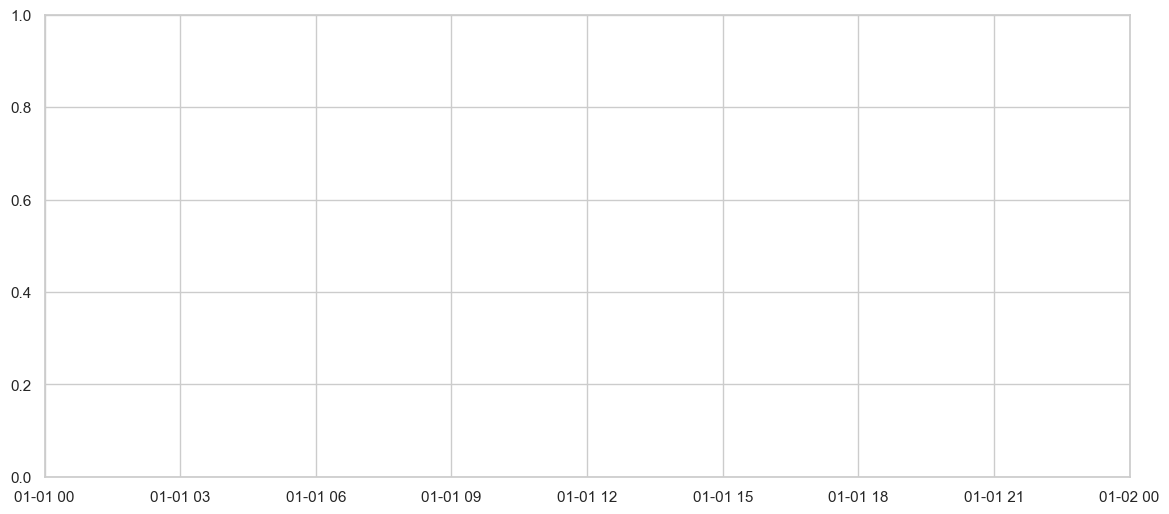

In [68]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

sns.lineplot(data=weather, x="datetime", y="day_temp", label="Temperature", color="blue")
sns.lineplot(data=weather, x="datetime", y="day_tempmax", label="Max Temperature", color="red")
sns.lineplot(data=weather, x="datetime", y="day_tempmin", label="Min Temperature", color="green")

plt.title("Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)

Thіі visualization show the trend in humidity over time. The plot illustrates the daily humidity, including maximum and minimum values.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

sns.lineplot(data=weather, x="datetime", y="day_humidity", color="purple")

plt.title("Humidity Over Time")
plt.xlabel("Date")
plt.ylabel("Humidity (%)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

This histogram shows the distribution of temperatures over time, with a kernel density estimate (KDE) to illustrate the probability density.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.histplot(weather["day_temp"], kde=True, color="blue", bins=30)

plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

This line plot compares the daily minimum and maximum temperatures over time.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

sns.lineplot(data=weather, x="datetime", y="day_tempmax", label="Max Temperature", color="red")
sns.lineplot(data=weather, x="datetime", y="day_tempmin", label="Min Temperature", color="green")

plt.title("Comparison of Min and Max Temperatures")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")

plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

This line plot shows the hourly temperature throughout the day, along with the daily maximum and minimum temperatures for comparison.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

# Plotting the hourly temperature, max temperature, and min temperature
sns.lineplot(data=weather, x="datetime", y="hour_temp", label="Hourly Temperature", color="blue")
sns.lineplot(data=weather, x="datetime", y="day_tempmax", label="Max Temperature", color="red")
sns.lineplot(data=weather, x="datetime", y="day_tempmin", label="Min Temperature", color="green")

plt.title("Hourly Temperature Comparison")
plt.xlabel("Time of Day")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()


This line plot shows the hourly humidity throughout the day, providing insights into how humidity changes over time.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

sns.lineplot(data=weather, x="datetime", y="hour_humidity", color="purple")

plt.title("Hourly Humidity Throughout the Day")
plt.xlabel("Time of Day")
plt.ylabel("Humidity (%)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

This scatter plot shows the relationship between temperature and humidity, allowing us to see how they are correlated throughout the day.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

sns.scatterplot(data=weather, x="hour_temp", y="hour_humidity", color="orange")

plt.title("Temperature vs Humidity throughout the Day")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")

plt.tight_layout()
plt.show()

This plot contains three parameters:

1. *Max Temperature by Region*: This bar chart shows the average maximum temperature for each region.
2. *Wind Speed by Region*: This bar chart displays the average wind speed for each region.
3. *Humidity by Region*: This bar chart represents the average humidity for each region.

In [ ]:
region_temp_max = weather.groupby("city_address")["day_tempmax"].mean().sort_values(ascending=False)
region_wind_speed = weather.groupby("city_address")["day_windspeed"].mean().sort_values(ascending=False)
region_humidity = weather.groupby("city_address")["day_humidity"].mean().sort_values(ascending=False)

# plot for max temperature
plt.figure(figsize=(14, 6))
sns.barplot(x=region_temp_max.index, y=region_temp_max.values, color="red")
plt.title("Max Temperature by Region")
plt.xlabel("Region")
plt.ylabel("Max Temperature (°C)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# plot for wind speed
plt.figure(figsize=(14, 6))
sns.barplot(x=region_wind_speed.index, y=region_wind_speed.values, color="blue")
plt.title("Wind Speed by Region")
plt.xlabel("Region")
plt.ylabel("Wind Speed (km/h)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# plot for humidity
plt.figure(figsize=(14, 6))
sns.barplot(x=region_humidity.index, y=region_humidity.values, color="purple")
plt.title("Humidity by Region")
plt.xlabel("Region")
plt.ylabel("Humidity (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This bar chart shows the average precipitation (in millimeters) for each region, allowing comparison of how much precipitation different regions receive on average.

In [ ]:
region_precip = weather.groupby("city_address")["day_precip"].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=region_precip.index, y=region_precip.values, color="blue")
plt.title("Average Precipitation by Region")
plt.xlabel("Region")
plt.ylabel("Average Precipitation (mm)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This box plot shows the distribution of temperatures by region, displaying the median, quartiles, and any outliers (extreme values).

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

# Box plot для температури по регіонах
sns.boxplot(x="city_address", y="day_temp", data=weather)

plt.title("Temperature Distribution by Region")
plt.xlabel("Region")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

This heatmap shows the correlation between different weather parameters. The color intensity indicates the strength of the correlation, with positive correlations shown in warmer colors (red) and negative correlations in cooler colors (blue). The values on the heatmap represent the correlation coefficient between the parameters.

In [ ]:
weather_corr = weather[["day_temp", "day_humidity", "day_windspeed", "day_precip", "day_tempmax", "day_tempmin"]]

corr_matrix = weather_corr.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

plt.title("Correlation Heatmap of Weather Parameters")
plt.tight_layout()
plt.show()

This scatter plot shows the relationship between temperature and wind speed, with each point representing a specific time period. It helps to visualize if there's any correlation or pattern between these two weather parameters.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

sns.scatterplot(data=weather, x="day_temp", y="day_windspeed", color="green")

plt.title("Temperature vs Wind Speed")
plt.xlabel("Temperature (°C)")
plt.ylabel("Wind Speed (km/h)")

plt.tight_layout()
plt.show()

This pair plot visualizes the relationships between multiple weather parameters. Each scatter plot shows the correlation between two variables, and the diagonal displays the distribution of each individual variable.

In [ ]:
sns.set(style="whitegrid")

weather_subset = weather[["day_temp", "day_humidity", "day_windspeed", "day_precip"]]

sns.pairplot(weather_subset)

plt.tight_layout()
plt.show()

This line plot shows the temperature trend throughout the day, comparing the current temperature with the maximum and minimum temperatures. It helps to visualize the temperature fluctuations over time and identify the periods with the largest variations.

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))

sns.lineplot(data=weather, x="datetime", y="hour_temp", label="Current Temperature", color="blue")
sns.lineplot(data=weather, x="datetime", y="day_tempmax", label="Max Temperature", color="red")
sns.lineplot(data=weather, x="datetime", y="day_tempmin", label="Min Temperature", color="green")

plt.title("Temperature Trend Throughout the Day")
plt.xlabel("Time of Day")
plt.ylabel("Temperature (°C)")

plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

This bar chart compares the average wind speed in each region, helping to identify where the strongest winds are.

In [ ]:
region_avg_wind_speed = weather.groupby("city_address")["day_windspeed"].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=region_avg_wind_speed.index, y=region_avg_wind_speed.values, color="blue")

# Додаємо заголовок та підписи до осей
plt.title("Average Wind Speed by Region")
plt.xlabel("Region")
plt.ylabel("Average Wind Speed (km/h)")

plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Preparing data for merging

In [69]:
weather.head()

,city_latitude,city_longitude,city_resolvedAddress,day_tempmax,day_tempmin,day_temp,day_precipcover,day_sunriseEpoch,day_sunsetEpoch,day_moonphase,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,datetime,sunrise_datetime,sunset_datetime
0,50.7469,25.3263,"Луцьк, Луцький район, Україна",4.9,0.7,2.6,4.17,1645679616,1645717866,0.77,...,1020.0,0.0,91.5,0.0,0.1,0.0,Overcast,2022-02-24 00:00:00,2022-02-24 07:13:36,2022-02-24 17:51:06
1,50.7469,25.3263,"Луцьк, Луцький район, Україна",4.9,0.7,2.6,4.17,1645679616,1645717866,0.77,...,1021.0,0.2,88.2,0.0,0.1,0.0,Partially cloudy,2022-02-24 01:00:00,2022-02-24 07:13:36,2022-02-24 17:51:06
2,50.7469,25.3263,"Луцьк, Луцький район, Україна",4.9,0.7,2.6,4.17,1645679616,1645717866,0.77,...,1022.0,10.0,100.0,0.0,0.1,0.0,Overcast,2022-02-24 02:00:00,2022-02-24 07:13:36,2022-02-24 17:51:06
3,50.7469,25.3263,"Луцьк, Луцький район, Україна",4.9,0.7,2.6,4.17,1645679616,1645717866,0.77,...,1021.0,0.1,92.0,0.0,0.1,0.0,Overcast,2022-02-24 03:00:00,2022-02-24 07:13:36,2022-02-24 17:51:06
4,50.7469,25.3263,"Луцьк, Луцький район, Україна",4.9,0.7,2.6,4.17,1645679616,1645717866,0.77,...,1021.0,0.0,93.8,0.0,0.1,0.0,Overcast,2022-02-24 04:00:00,2022-02-24 07:13:36,2022-02-24 17:51:06


### Dataset Preparation Summary

The dataset has been fully analyzed and cleaned. Since we are only using `sunset_datetime` and `sunrise_datetime` times for modeling purposes, we can safely drop the datetime-related columns and retain only the **epoch equivalents**.

Regarding `city_latitude` and `city_longitude`, their usefulness as features is still uncertain. To evaluate their impact, we will train and test the model both **with and without** these features and decide based on the results.

In [71]:
weather["city"] = weather["city_resolvedAddress"].apply(lambda x: x.split(",")[0])
weather["city"] = weather["city"].replace("Хмельницька область", "Хмельницький")

In [75]:
weather.drop(["sunset_datetime", "sunrise_datetime", "city_resolvedAddress"], axis=1, inplace=True)

In [76]:
weather.to_csv("../prepared_data/weather_prepared.csv")